In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Epoch 0/9
----------
train Loss: 0.5716 Acc: 0.7076
test Loss: 0.4042 Acc: 0.8180
Epoch 1/9
----------
train Loss: 0.5197 Acc: 0.7468
test Loss: 0.4308 Acc: 0.8180
Epoch 2/9
----------
train Loss: 0.4966 Acc: 0.7599
test Loss: 0.3470 Acc: 0.8559
Epoch 3/9
----------
train Loss: 0.4861 Acc: 0.7716
test Loss: 0.3512 Acc: 0.8619
Epoch 4/9
----------
train Loss: 0.4732 Acc: 0.7807
test Loss: 0.3621 Acc: 0.8438
Epoch 5/9
----------
train Loss: 0.4580 Acc: 0.7921
test Loss: 0.3309 Acc: 0.8793
Epoch 6/9
----------
train Loss: 0.4497 Acc: 0.8015
test Loss: 0.3019 Acc: 0.8747
Epoch 7/9
----------
train Loss: 0.4410 Acc: 0.8064
test Loss: 0.3083 Acc: 0.8660
Epoch 8/9
----------
train Loss: 0.4345 Acc: 0.8079
test Loss: 0.3278 Acc: 0.8650
Epoch 9/9
----------
train Loss: 0.4151 Acc: 0.8177
test Loss: 0.2862 Acc: 0.8880


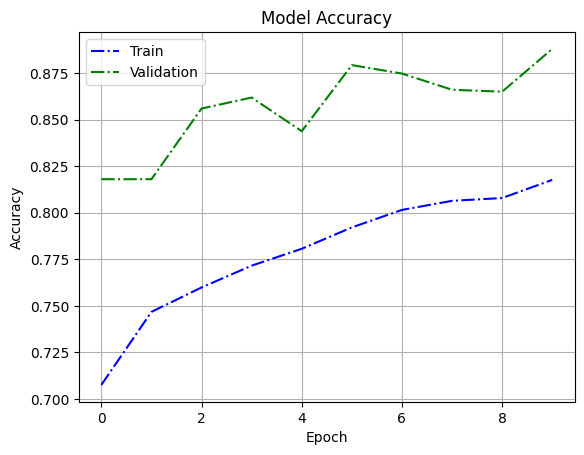

In [ ]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
import numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define data directories
data_dir = "/content/drive/My Drive/AI Semester/Fundus Glaucoma Detection Data  [PyTorch format] dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transformations for data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pretrained model (e.g., ResNet-50)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes: with and without glaucoma

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train the model
def train_model(model, criterion, optimizer, num_epochs=10):
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Record accuracy for plotting
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                test_acc_history.append(epoch_acc)

    return model, train_acc_history, test_acc_history

# Train the model
model, train_acc_history, test_acc_history = train_model(model, criterion, optimizer, num_epochs=10)

# Convert tensors to numpy arrays
train_acc_np = [acc.item() for acc in train_acc_history]
test_acc_np = [acc.item() for acc in test_acc_history]

# Plot accuracy
plt.plot(train_acc_np, 'b-.', label='Train')
plt.plot(test_acc_np, 'g-.', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_classes,predicted_classes), annot=True, cmap='Blues', fmt='g',
             xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()